# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 4/19/2024
- Updated: 2/1/2025

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Data

##### Park x Weather Factors

In [3]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))

##### Plate Appearances

In [4]:
complete_dataset = create_pa_inputs(multiplier_df, start_year=2013, end_year=2024, short=50, long=300, adjust=True, generate=False, write=False)

##### Steamer

In [5]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

In [6]:
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')

### Clean

##### MLB Stats API

In [7]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 2.02 s
Wall time: 2.03 s


##### Steamer

Clean

In [8]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

Scale

In [9]:
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])

Read in pitchers

Clean

In [10]:
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

Scale

In [11]:
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

##### Merge

Format dates

In [12]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [13]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [14]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [15]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [16]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [17]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter', 
    direction='backward'
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',
    direction='backward'
)

##### Impute

For players with insufficient sample sizes, stats are imputed

Option 1: Steamer

First, remove from dataset if ever missing FG/Steamer stats

In [18]:
complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

In [19]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L', 'imp_b']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L', 'imp_p']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

Option 2: 0s

In [20]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Select Data

Drop early observations

In [21]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [22]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [23]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

### Select Variables

Batter Inputs

In [24]:
batter_input_list = batter_inputs

Pitcher Inputs

In [25]:
pitcher_input_list = pitcher_inputs

Hand Inputs

In [26]:
hand_input_list = ['p_L', 'b_L']

Imputation Inputs

In [27]:
imp_input_list = ['imp_b', 'imp_p']

Starter Input(s)

In [28]:
starter_input_list = ['starter']

Cumulative Inning Inputs

In [29]:
cumulative_inning_input_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [30]:
cumulative_inning_input_list.remove('rbi_inning')

Cumulative Game Inputs

In [31]:
cumulative_game_input_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

In [32]:
cumulative_game_input_list.remove('rbi_game')

Game State Inputs

In [33]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [34]:
game_state_input_list = ['onFirst', 'onSecond', 'onThird', 'top', 'score_diff', 'prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced']

Inning Inputs

In [35]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [36]:
inning_input_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Out Inputs

In [37]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_pre'] == out).astype(int)

In [38]:
out_input_list = ['outs_0', 'outs_1', 'outs_2']

Venue Inputs

In [39]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [40]:
venue_input_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id"]

Multiplier Inputs

In [41]:
for event in events_list:
    # Assign multiplier for their 
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], complete_merged_df[f'{event}_wfx_r'])

In [42]:
multiplier_input_list = [f'{event}_wfx' for event in events_list]

Inputs

In [43]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + venue_input_list + multiplier_input_list

Outputs

In [44]:
output_list = ['is_out', 'eventsModel']

Other variables

In [45]:
additional_list = ['pa_b', 'pa_p', 'year', 'date', 'gamePk', 'atBatIndex', 'venue_id', 'batterName', 'pitcherName']

Variables to keep

In [46]:
keep_list = input_list + output_list + additional_list

### Shift

Many batter and pitcher stats are calculated at the end of the plate appearance. For prediction purposes, we need these stats coming into the plate appearance, so we need to shift.

##### Batter Inputs

Sort

In [47]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [48]:
complete_merged_df[batter_inputs + ['ab_b', 'pa_b', 'imp_b']] = complete_merged_df.groupby(['batter', 'pitchHand'])[batter_inputs + ['ab_b', 'pa_b', 'imp_b']].shift(1)

##### Pitcher Inputs

Sort

In [49]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [50]:
complete_merged_df[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']] = complete_merged_df.groupby(['pitcher', 'batSide'])[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']].shift(1)

##### Inning Sums

Sort

In [51]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [52]:
complete_merged_df[cumulative_inning_input_list] = complete_merged_df.groupby(['gamePk', 'inning', 'pitcher'])[cumulative_inning_input_list].shift(1)
complete_merged_df[cumulative_inning_input_list] = complete_merged_df[cumulative_inning_input_list].fillna(0)

##### Game Sums

Sort

In [53]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [54]:
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df.groupby(['gamePk', 'pitcher'])[cumulative_game_input_list + ['times_faced']].shift(1)
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df[cumulative_game_input_list + ['times_faced']].fillna(0)

### Model Dataset

Create Model Dataset

In [55]:
model_dataset = complete_merged_df[keep_list]

model_dataset.dropna(subset=input_list, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

Free up memory

In [56]:
del complete_merged_df, complete_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df,  batter_predictions, pitcher_predictions

In [57]:
n1 = len(input_list) + 1

### Train/Test Split

Split

In [58]:
np.random.seed(42)
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

Create masks to identify training and testing datasets

Note: to train on the entire dataset, you can simply set split = 0 for the entire dataset

In [59]:
training_mask = (model_dataset['split'] == 0)
out_mask = (model_dataset['is_out'] == 1)

### Binary

In [60]:
binary_stat_list = []

##### Train

In [212]:
%%time
# Neural network layers
# layers = (n1,n1,)
layers = (390, n1,4)
# layers = (196,196,196,196,196,196)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
iters = 1000
alpha = 0.0001
learning_rate = 0.00001
batch_size='auto'
# batch_size=16
random_state = random.randint(1,99999)
print(random_state)
num_models = 3
cv = 1 # Unused
n_jobs = -1

binary_filename = f"predict_binary_{layers_str}_{todaysdate}.sav"
print(binary_filename)


# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, 
                  random_state=random_state+i, max_iter=iters, batch_size=batch_size) for i in range(num_models)]

# Create the ensemble classifier using VotingClassifier
predict_binary = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=n_jobs).fit(model_dataset[training_mask][input_list], model_dataset[training_mask][['is_out']].values.ravel())

# Save model
pickle.dump(predict_binary, open(os.path.join(model_path, "M03. Plate Appearances", binary_filename), 'wb'))

13739
predict_binary_3901954_20250223.sav
CPU times: total: 10.5 s
Wall time: 15min 7s


##### Predict

In [213]:
all_outputs = list(predict_binary.classes_)
all_outputs_pred = ["is_safe_pred", "is_out_pred"]

model_dataset.loc[~training_mask, all_outputs_pred] = predict_binary.predict_proba(model_dataset[~training_mask][input_list])

##### Quantiles

In [214]:
# Set quantiles
quantiles = 10

# Create quantiles
for var in ['is_out']:    
    # Create actual outcome column
    model_dataset.loc[~training_mask, f'{var}_act'] = (model_dataset.loc[~training_mask, 'eventsModel'] == var).astype(int)

    # Create actual is_out value
    if var == "is_out":
        model_dataset.loc[~training_mask, f'{var}_act'] = model_dataset.loc[~training_mask, 'eventsModel'].isin(['so', 'lo', 'po', 'go', 'fo']).astype(int)
    
    # Create deciles
    model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False)
    
    # Create aggregated dataframe
    globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_year_df"] = model_dataset.query('year >= 2024').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_venue_df"] = model_dataset.query('venue_id == 19').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

##### Graph

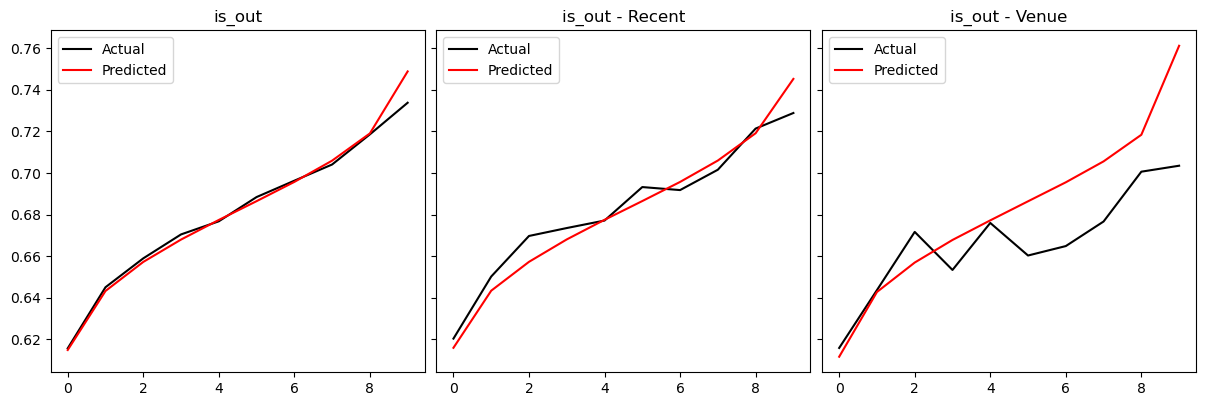

In [215]:
# Create figure and 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

var = "is_out"

# List of dataframes to plot
df_list = [globals()[f"{var}_df"], globals()[f"{var}_year_df"], globals()[f"{var}_venue_df"]]
titles = [var, f"{var} - Recent", f"{var} - Venue"]

# Loop through and plot each dataframe on separate axes
for ax, df, title in zip(axes, df_list, titles):
    ax.plot(df[f'{var}_quantile'], df[f'{var}_act'], color='black', label="Actual")
    ax.plot(df[f'{var}_quantile'], df[f'{var}_pred'], color='red', label="Predicted")
    ax.set_title(title)
    ax.legend()

# Adjust layout
fig.tight_layout(pad=0.5)

# Show figure
plt.show()

##### Stats

In [216]:
var = "is_out"
year = 2024

# All
actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
mult = actual/predicted
stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
# globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index() # graphing all, delete these
globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
mse = globals()[f"{var}_df"]['se'].mean()
all_df = pd.DataFrame(["All", actual, predicted, mult, stdev, mse])

# Year
actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
mult = actual/predicted
stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
# globals()[f"{var}_year_df"] = model_dataset.query('year >= 2024').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
mse = globals()[f"{var}_year_df"]['se'].mean()
recent_df = pd.DataFrame([str(int(year)), actual, predicted, mult, stdev, mse])

# DataFrame
binary_stat_df = pd.concat([all_df, recent_df], axis=1).T.reset_index(drop=True)
binary_stat_df.columns = ['Year', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
binary_stat_df['Layers'] = str(layers)
binary_stat_df['Models'] = num_models
binary_stat_df['State'] = random_state
binary_stat_df[['Year', 'Layers', 'Models', 'State', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

,Year,Layers,Models,State,Actual,Predicted,Multiplier,Std. Dev,MSE
0,All,"(390, 195, 4)",3,13739,0.680782,0.681648,0.998729,0.037869,0.000025
1,2024,"(390, 195, 4)",3,13739,0.688004,0.687537,1.000680,0.035423,0.000060


In [217]:
binary_stat_list.append(binary_stat_df)
all_binary_stat_df = pd.concat(binary_stat_list)
all_binary_stat_df

,Year,Actual,Predicted,Multiplier,Std. Dev,MSE,Layers,Models,State
0,All,0.680782,0.678949,1.002700,0.037378,0.000030,"(195, 4)",3,71030
1,2024,0.688004,0.685411,1.003783,0.035518,0.000109,"(195, 4)",3,71030
0,All,0.680782,0.678542,1.003302,0.035387,0.000023,"(195, 4)",3,31543
1,2024,0.688004,0.685502,1.003650,0.034450,0.000063,"(195, 4)",3,31543
0,All,0.680782,0.682160,0.997981,0.029238,0.000015,"(195, 4)",3,18500
1,2024,0.688004,0.686745,1.001834,0.028633,0.000050,"(195, 4)",3,18500
0,All,0.680782,0.678169,1.003853,0.034310,0.000030,"(195, 4)",3,58240
1,2024,0.688004,0.683707,1.006286,0.033272,0.000115,"(195, 4)",3,58240
0,All,0.680782,0.681600,0.998800,0.033553,0.000004,"(195, 4)",3,47445
1,2024,0.688004,0.686016,1.002899,0.033051,0.000056,"(195, 4)",3,47445


In [218]:
# Maybe loop just keep making models then select?

### Outs

In [67]:
out_stat_list = []

##### Train

In [168]:
%%time
# Neural network layers
# layers = (n1,n1)
layers = (10,)
# layers = (196,196,196,196,196,196)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
iters = 1000
alpha = 0.0001
learning_rate = 0.00001
batch_size='auto'
random_state = random.randint(1,99999)
print(random_state)
num_models = 3
cv = 1 # Unused
n_jobs = -1

outs_filename = f"predict_outs_{layers_str}_{todaysdate}.sav"
print(outs_filename)


# Define the individual models in the ensemble
models = [MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, 
          random_state=random_state+i, max_iter=iters, batch_size=batch_size) for i in range(num_models)]

# Create the ensemble classifier using VotingClassifier
predict_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=n_jobs).fit(model_dataset[training_mask][out_mask][input_list], model_dataset[training_mask][out_mask][['eventsModel']].values.ravel())

# Save model
pickle.dump(predict_outs, open(os.path.join(model_path, "M03. Plate Appearances", outs_filename), 'wb'))

93666
predict_outs_10_20250222.sav
CPU times: total: 15.6 ms
Wall time: 8.24 ms


##### Predict

In [69]:
# Predict out types
outs_outputs = list(predict_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

model_dataset.loc[~training_mask & out_mask, outs_outputs_pred] = predict_outs.predict_proba(model_dataset[~training_mask][out_mask][input_list])

##### Quantiles

In [70]:
year = 2022
venue = 19

for var in outs_outputs:
    # Create actual outcome column
    model_dataset.loc[~training_mask & out_mask, f'{var}_act'] = (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == var).astype(int)
    
    # Create deciles
    model_dataset.loc[~training_mask & out_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask & out_mask, f'{var}_pred'], 10, labels=False)
    
    # Create aggregated dataframe
    globals()[f"{var}_df"] = model_dataset.loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

##### Graph

Graphing _venue


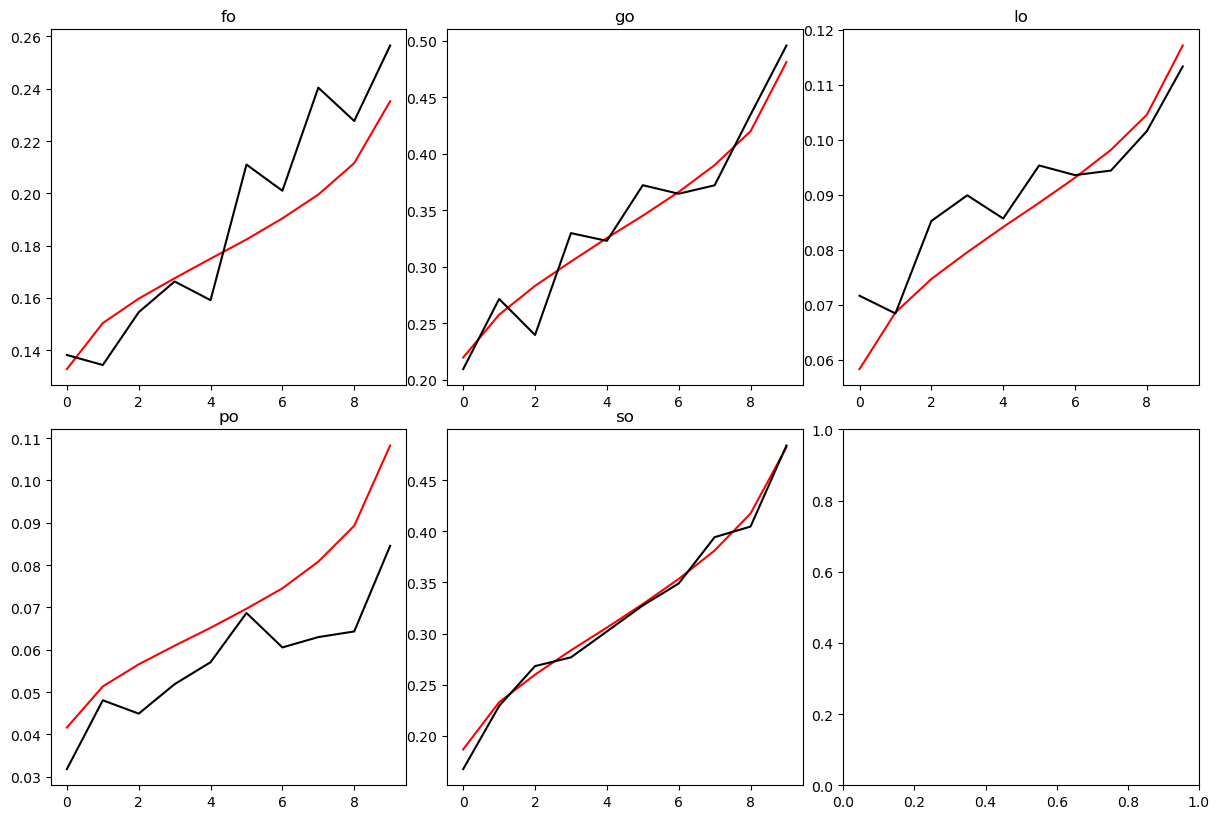

In [71]:
graph_options = ["", "_year", "_venue"]
graph_index = 2
graph = graph_options[graph_index]
print(f"Graphing {graph}")

# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

##### Stats

In [72]:
# All
all_df_list = []
for var in outs_outputs:
    actual = model_dataset.loc[~training_mask & out_mask][f'{var}_act'].mean()
    predicted = model_dataset.loc[~training_mask & out_mask][f'{var}_pred'].mean()
    mult = actual/predicted
    stdev = model_dataset.loc[~training_mask & out_mask][f'{var}_pred'].std()
    globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
    mse = globals()[f"{var}_df"]['se'].mean()
    all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
    all_df_list.append(all_df)

all_dfs = pd.concat(all_df_list, axis=1).T

# Year
recent_df_list = []
for var in outs_outputs:
    actual = model_dataset.query(f'year >= {year}').loc[~training_mask & out_mask][f'{var}_act'].mean()
    predicted = model_dataset.query(f'year == {year}').loc[~training_mask & out_mask][f'{var}_pred'].mean()
    mult = actual/predicted
    stdev = model_dataset.query(f'year == {year}').loc[~training_mask & out_mask][f'{var}_pred'].std()
    globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
    mse = globals()[f"{var}_year_df"]['se'].mean()
    recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
    recent_df_list.append(recent_df)

recent_dfs = pd.concat(recent_df_list, axis=1).T

# # DataFrame
out_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
out_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
out_stat_df['Layers'] = str(layers)
out_stat_df['Models'] = num_models
out_stat_df['State'] = random_state
out_stat_df[['Year', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

,Year,Layers,Models,State,Output,Actual,Predicted,Multiplier,Std. Dev,MSE
0,All,"(10,)",3,3240,fo,0.181909,0.180607,1.007207,0.029440,0.000109
1,All,"(10,)",3,3240,go,0.339117,0.337883,1.003652,0.075214,0.000051
2,All,"(10,)",3,3240,lo,0.085386,0.086567,0.986356,0.017198,0.000004
3,All,"(10,)",3,3240,po,0.069712,0.070310,0.991496,0.019896,0.000017
4,All,"(10,)",3,3240,so,0.323876,0.324633,0.997669,0.087171,0.000039
5,2022,"(10,)",3,3240,fo,0.192998,0.182183,1.059365,0.029513,0.000257
6,2022,"(10,)",3,3240,go,0.329001,0.335107,0.981779,0.075441,0.000104
7,2022,"(10,)",3,3240,lo,0.082276,0.085572,0.961489,0.016630,0.000009
8,2022,"(10,)",3,3240,po,0.068371,0.069953,0.977375,0.019326,0.000036
9,2022,"(10,)",3,3240,so,0.327354,0.327185,1.000516,0.086076,0.000074


In [73]:
out_stat_list.append(out_stat_df)
all_out_stat_df = pd.concat(out_stat_list)
all_out_stat_df

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,Layers,Models,State
0,All,fo,0.181909,0.180607,1.007207,0.029440,0.000109,"(10,)",3,3240
1,All,go,0.339117,0.337883,1.003652,0.075214,0.000051,"(10,)",3,3240
2,All,lo,0.085386,0.086567,0.986356,0.017198,0.000004,"(10,)",3,3240
3,All,po,0.069712,0.070310,0.991496,0.019896,0.000017,"(10,)",3,3240
4,All,so,0.323876,0.324633,0.997669,0.087171,0.000039,"(10,)",3,3240
5,2022,fo,0.192998,0.182183,1.059365,0.029513,0.000257,"(10,)",3,3240
6,2022,go,0.329001,0.335107,0.981779,0.075441,0.000104,"(10,)",3,3240
7,2022,lo,0.082276,0.085572,0.961489,0.016630,0.000009,"(10,)",3,3240
8,2022,po,0.068371,0.069953,0.977375,0.019326,0.000036,"(10,)",3,3240
9,2022,so,0.327354,0.327185,1.000516,0.086076,0.000074,"(10,)",3,3240


In [74]:
all_out_stat_df.sort_values('Layers').groupby(['Layers', 'State', 'Year'])[['Multiplier', 'MSE']].mean()

Multiplier      MSE
Layers State Year                    
(10,)  3240  2022   0.996105 0.000096
             All    0.997276 0.000044

### Safe

In [97]:
safe_stat_list = []

In [163]:
%%time
# layers = (10,)
layers = (n1,10,5)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
iters = 100
alpha = 0.0001
learning_rate = 0.00001
batch_size=8
random_state = random.randint(1,99999)
print(random_state)
# random_state = 95835
num_models = 3

safe_filename = f"predict_safe_{layers_str}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, 
                        random_state=random_state+i, max_iter=iters, batch_size=batch_size) for i in range(num_models)]

# Create the ensemble classifier using VotingClassifier
predict_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(model_dataset[training_mask][~out_mask][input_list], model_dataset[training_mask][~out_mask][['eventsModel']].values.ravel())

# Save model
pickle.dump(predict_safe, open(os.path.join(model_path, "M03. Plate Appearances", safe_filename), 'wb'))

13943
predict_safe_195105_20250223.sav
CPU times: total: 9.86 s
Wall time: 22min 41s


In [164]:
# Predict safe types
safe_outputs = list(predict_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

model_dataset.loc[~training_mask & ~out_mask, safe_outputs_pred] = predict_safe.predict_proba(model_dataset[~training_mask][~out_mask][input_list])

In [165]:
year = 2024
venue = 19

# Create deciles
for var in safe_outputs:    
    # Create actual outcome column
    model_dataset.loc[~training_mask & ~out_mask, f'{var}_act'] = (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == var).astype(int)
    
    # Create deciles
    model_dataset.loc[~training_mask & ~out_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask & ~out_mask, f'{var}_pred'], 10, labels=False)
    
    # Create aggregated dataframe
    globals()[f"{var}_df"] = model_dataset.loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

Graphing _year


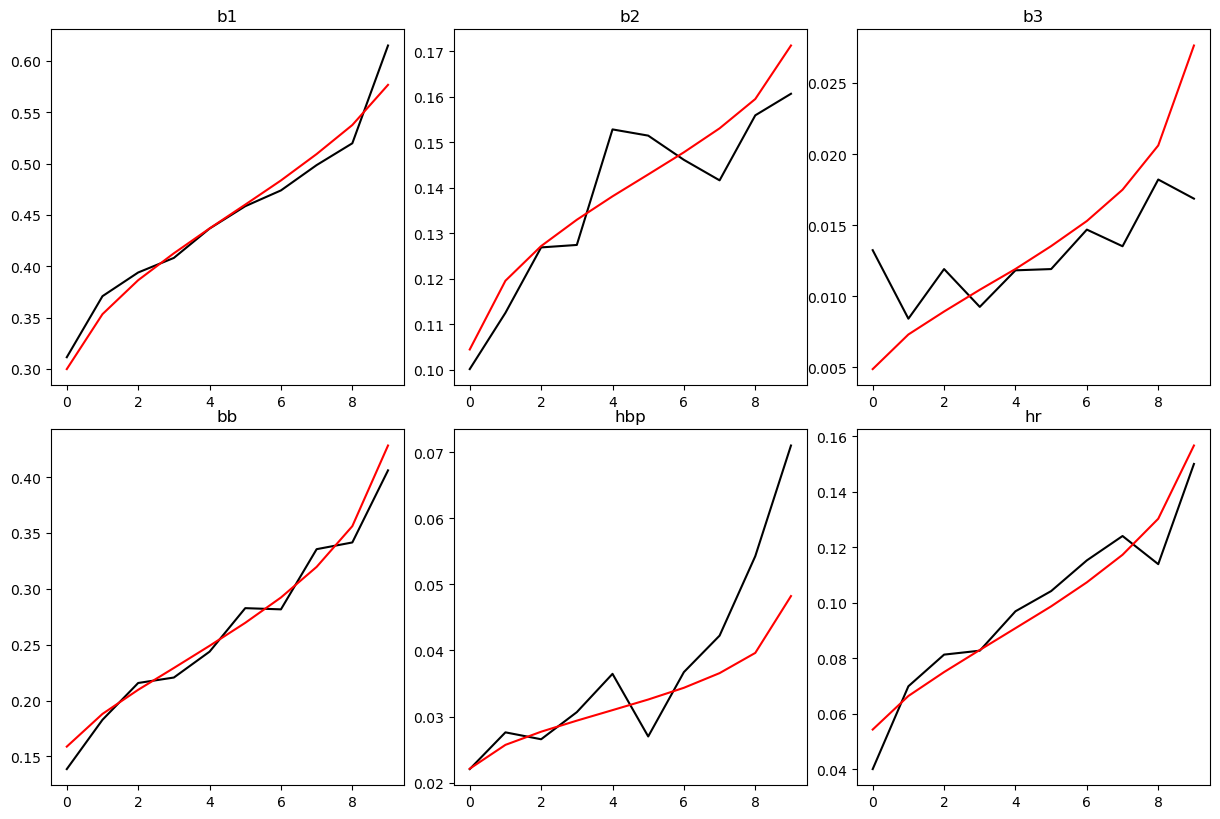

In [166]:
graph_options = ["", "_year", "_venue"]
graph_index = 1
graph = graph_options[graph_index]
print(f"Graphing {graph}")

# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

##### Stats

In [167]:
# All
all_df_list = []
for var in safe_outputs:
    actual = model_dataset.loc[~training_mask & ~out_mask][f'{var}_act'].mean()
    predicted = model_dataset.loc[~training_mask & ~out_mask][f'{var}_pred'].mean()
    mult = actual/predicted
    stdev = model_dataset.loc[~training_mask & ~out_mask][f'{var}_pred'].std()
    globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
    mse = globals()[f"{var}_df"]['se'].mean()
    all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
    all_df_list.append(all_df)

all_dfs = pd.concat(all_df_list, axis=1).T

# Year
recent_df_list = []
for var in safe_outputs:
    actual = model_dataset.query(f'year >= {year}').loc[~training_mask & ~out_mask][f'{var}_act'].mean()
    predicted = model_dataset.query(f'year == {year}').loc[~training_mask & ~out_mask][f'{var}_pred'].mean()
    mult = actual/predicted
    stdev = model_dataset.query(f'year == {year}').loc[~training_mask & ~out_mask][f'{var}_pred'].std()
    globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
    mse = globals()[f"{var}_year_df"]['se'].mean()
    recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
    recent_df_list.append(recent_df)

recent_dfs = pd.concat(recent_df_list, axis=1).T

# # DataFrame
safe_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
safe_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
safe_stat_df['Layers'] = str(layers)
safe_stat_df['Models'] = num_models
safe_stat_df['State'] = random_state
safe_stat_df[['Year', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

,Year,Layers,Models,State,Output,Actual,Predicted,Multiplier,Std. Dev,MSE
0,All,"(195, 10, 5)",3,13943,b1,0.449702,0.445407,1.009642,0.082324,0.000093
1,All,"(195, 10, 5)",3,13943,b2,0.139234,0.139723,0.996498,0.019243,0.000007
2,All,"(195, 10, 5)",3,13943,b3,0.013203,0.013820,0.955341,0.006684,0.000022
3,All,"(195, 10, 5)",3,13943,bb,0.264014,0.270267,0.976863,0.079686,0.000078
4,All,"(195, 10, 5)",3,13943,hbp,0.034034,0.032724,1.040049,0.007607,0.000062
5,All,"(195, 10, 5)",3,13943,hr,0.099813,0.098058,1.017895,0.030148,0.000076
6,2024,"(195, 10, 5)",3,13943,b1,0.453367,0.450575,1.006198,0.080367,0.000251
7,2024,"(195, 10, 5)",3,13943,b2,0.137402,0.139416,0.985551,0.018687,0.000065
8,2024,"(195, 10, 5)",3,13943,b3,0.012906,0.013646,0.945779,0.006428,0.000022
9,2024,"(195, 10, 5)",3,13943,bb,0.262959,0.267755,0.982089,0.077176,0.000181


In [168]:
safe_stat_list.append(safe_stat_df)
all_safe_stat_df = pd.concat(safe_stat_list)
all_safe_stat_df

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,Layers,Models,State
0,All,b1,0.449702,0.463598,0.970026,0.091662,0.000246,"(195, 195)",3,57647
1,All,b2,0.139234,0.132588,1.050125,0.026453,0.000082,"(195, 195)",3,57647
2,All,b3,0.013203,0.012544,1.052554,0.006433,0.000001,"(195, 195)",3,57647
3,All,bb,0.264014,0.262869,1.004357,0.087134,0.000018,"(195, 195)",3,57647
4,All,hbp,0.034034,0.031084,1.094923,0.016725,0.000018,"(195, 195)",3,57647
5,All,hr,0.099813,0.097318,1.025637,0.041808,0.000019,"(195, 195)",3,57647
6,2024,b1,0.453367,0.470553,0.963478,0.089849,0.000478,"(195, 195)",3,57647
7,2024,b2,0.137402,0.131283,1.046606,0.026948,0.000133,"(195, 195)",3,57647
8,2024,b3,0.012906,0.011440,1.128208,0.005490,0.000013,"(195, 195)",3,57647
9,2024,bb,0.262959,0.259518,1.013259,0.084639,0.000195,"(195, 195)",3,57647


In [169]:
all_safe_stat_df.groupby(['Layers', 'Year', 'State'])[['Multiplier', 'MSE']].mean()

Multiplier      MSE
Layers         Year State                    
(195, 10)      2024 147     1.029873 0.000105
                    29537   1.032003 0.000129
                    69117   1.004264 0.000097
               All  147     1.008063 0.000016
                    29537   1.013802 0.000026
                    69117   0.988567 0.000028
(195, 10, 5)   2024 13146   1.005488 0.000092
                    13943   1.010658 0.000113
               All  13146   0.992807 0.000018
                    13943   0.999381 0.000056
(195, 100, 10) 2024 12017   1.015855 0.000097
               All  12017   0.996620 0.000048
(195, 195)     2024 32742   1.030540 0.000155
                    57647   1.057765 0.000167
                    72149   1.046965 0.000199
                    96960   1.022403 0.000119
               All  32742   1.011619 0.000056
                    57647   1.032937 0.000064
                    72149   1.026934 0.000088
                    96960   1.001339 0.000037